# Understanding L-BGFS

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

## Help Functions from PyCo Newton_linesearch

In [78]:
def first_wolfe_condition(fun, x0, fprime, direction, alpha, beta1):
    """
    p. 268, 11.19

    Keyword Arguments:
    fun         -- objective function to minimize
    x0          -- initial guess for solution
    fprime      -- Jacobian (gradient)
    direction   -- search direction (column vec)
    alpha       -- step size
    beta1       -- lower wolfe bound
    """
    return fun(x0+alpha*direction) <= fun(x0) + \
        alpha * beta1 * float(fprime(x0).T * direction)


In [31]:
def second_wolfe_condition(x0, fprime, direction, alpha, beta2):
    """
    p. 270, 11.21

    Keyword Arguments:
    x0        -- initial guess for solution
    fprime    -- Jacobian (gradient) of objective function
    direction -- search direction
    alpha     -- step size
    beta2     -- upper wolfe bound
    """
    return (float(fprime(x0 + alpha*direction).T * direction) >=
            beta2*float(fprime(x0).T * direction))


In [32]:
def modified_cholesky(symmat, maxiter = 20):
    """
    Modify a symmetric matrix A in order to make it positive definite. Returns
    a lower triangular matrix L and a scalar τ > 0 so that
              A + τI = LL^T
    Keyword Arguments:
    symmat -- symmetric matrix
    """
    fronorm = np.linalg.norm(symmat, ord='fro')
    if np.diag(symmat).min() > 0:
        tau = 0
    else:
        tau = .5*fronorm
    success = False
    I = np.eye(symmat.shape[0])

    for i in range(maxiter):
        try:
            L = np.linalg.cholesky(symmat + tau*I)
            return L, tau
        except np.linalg.LinAlgError:
            tau = max(2*tau, .5*fronorm)
    raise Exception("Couldn't factor")


In [86]:
import warnings
# implements the line search, p. 273, algo 11.2
def line_search(fun, x0, fprime, direction, alpha0, beta1=1e-4, beta2=0.99,
                step_factor=3., store_iterates=None, maxiter=40):
    """
    find a step size alpha that satisfies both conditions of Wolfe
    Keyword Arguments:
    fun         -- objective function to minimize
    x0          -- initial guess for solution
    fprime      -- Jacobian (gradient) of objective function
    direction   -- search direction
    alpha0      -- Initial guess for step size
    beta1       -- (default 1e-4)
    beta2       -- (default 0.99)
    step_factor -- (default 3.) step increase when too short
    store_iterates -- (default None) if set to 'iterate' the full iterates are
                   stored in module-level constant iterates
    maxiter     -- (default 20) abort and raise Exception after maxiter is
                   reached
    """
    alpha_l = 0
    alpha_r = float('inf')
    alpha = alpha0

    wolfe1 = first_wolfe_condition(fun, x0, fprime, direction, alpha, beta1)
    wolfe2 = second_wolfe_condition(x0, fprime, direction, alpha, beta2)

    iterates = list()
    counter = 0
    violation = 0
    if store_iterates == 'iterate':
        iterate = scipy.optimize.OptimizeResult(
            {'x': x0.copy(),
             'fun': fun(x0),
             'jac': fprime(x0),
             'alpha_i': alpha,
             'alpha_r': alpha_r,
             'alpha_l': alpha_l,
             'violation': 0})
        iterates.append(iterate)
    while not (wolfe1 and wolfe2):
        if counter == maxiter:
            warnings.warn(
                ("Line search did not converge. Are your jacobians correct? "
                 "wolfe1 = {}, wolfe2 = {}, alpha = {}, nit = {}.\n"
                 "If they are, machine precision has been reached. Currently,"
                 " progress regarding funval would be {}").format(
                     wolfe1, wolfe2, alpha, counter, float(alpha * fprime(x0).T*direction)))
            break
        if not wolfe1: # step too long
            alpha_r = alpha
            alpha = .5*(alpha_l + alpha_r)
            violation = 1

        elif wolfe1 and not wolfe2:
            alpha_l = alpha
            violation = 2
            if np.isfinite(alpha_r):
                alpha = .5*(alpha_l + alpha_r)
            else:
                alpha *= step_factor
        wolfe1 = first_wolfe_condition(fun, x0, fprime, direction, alpha, beta1)
        wolfe2 = second_wolfe_condition(x0, fprime, direction, alpha, beta2)
        if store_iterates == 'iterate':
            iterate = scipy.optimize.OptimizeResult(
                {'x': x0.copy(),
                 'fun': fun(x0),
                 'jac': fprime(x0),
                 'alpha_i': alpha,
                 'alpha_r': alpha_r,
                 'alpha_l': alpha_l,
                 'violation': violation})
            iterates.append(iterate)
        counter += 1

    result = scipy.optimize.OptimizeResult({'success': True,
                                            'x': alpha,
                                            'nit': counter,
                                            'violation':violation})

    if iterates:
        result['iterates'] = iterates
    return result


In [123]:
#Nocedal Book
def direction(gk, S, Y,iter,gamma = None):
    """
    
    :param gk: gradient  
    :param S: Vector of all previous Steps, sorted from the oldest to the newest
                size nxm, with m the number of Vecor to be stored
    :param H0: Initial guess for the inversaew
    :return: 
    """
    q = gk 
    n,m = S.shape
    
    alpha= np.zeros(m)
    rho = np.zeros(m)
    for i in range(m-1,max(m-iter,0)-1,-1): # This Loop is bad to parallelize because eaxh Iteration depend from one another
        print("i %i"%i)
        print(Y[:,i].T)
        print(S[:,i])
        rho[i] = 1/ (Y[:,i].T*S[:,i])
        alpha[i]= rho[i] * np.dot(S[:,i].T , q) 
        q -=  alpha[i] * Y[:,i]
        
    if gamma == None:    
        gamma = S[:,-1].T*Y[:,-1] / np.sum(np.asarray(Y[:,-1])**2)
    r = q*gamma 
    
    for i in range(max(m-iter,0),m): # here it's the same. Really Bad !
        r +=  S[:,i]*(alpha[i] - rho[i] * (Y[:,i].T*r))
        
    return r 


In [124]:
def test_fun(x):
    x.shape=(-1, 1)
    return .5*x[0, 0]**2 + x[0, 0]* np.cos(x[1, 0])

def test_jac(x):
    x.shape=(-1, 1)
    return np.matrix([[x[0, 0] + np.cos(x[1, 0])],
                      [-x[0, 0] * np.sin(x[1, 0])]])

def test_hess(x):
    x.shape=(-1, 1)
    return np.matrix([[           1.,        -np.sin(x[1, 0])],
                     [-np.sin(x[1, 0]), -x[0, 0] * np.cos(x[1, 0])]])

iter 0
p
[[ 1.54030231]
 [-0.84147098]]
4.547473508864641e-13
[[0. 0.]
 [0. 0.]]
[[ 0.00000000e+00  1.02251541e-12]
 [ 0.00000000e+00 -3.82693877e-13]]
iter 1
i 1
[[ 1.02251541e-12 -3.82693877e-13]]
[[0.]
 [0.]]
p
[[nan]
 [nan]]
4.547473508864641e-13
[[ 0. nan]
 [ 0. nan]]
[[ 0. nan]
 [ 0. nan]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Line search did not converge. Are your jacobians correct? wolfe1 = False, wolfe2 = True, alpha = 4.547473508864641e-13, nit = 40.
If they are, machine precision has been reached. Currently, progress regarding funval would be 1.4008967863156975e-12
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Line search did not converge. Are your jacobians correct? wolfe1 = False, wolfe2 = False, alpha = 4.547473508864641e-13, nit = 40.
If they are, machine precision has been reached. Currently, progress regarding funval would be nan


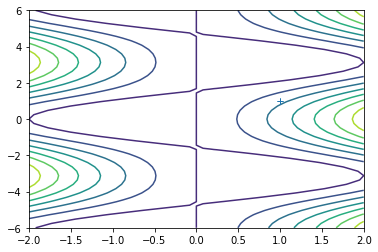

In [ ]:
xg, yg = np.linspace(-2, 2, 51), np.linspace(-6, 6, 51)
def mat_fun(x_g, x_):
    Z = np.zeros((xg.size, yg.size))

    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[j, i] = test_fun(np.array([xg[i], yg[j]]))
    return Z
X, Y = np.meshgrid(xg,yg)
plt.contour(X, Y, mat_fun(xg, yg))


x = np.matrix([1, 1.]).T

gamma = 1
grad = test_jac(x) 
tol = 1e-2
MAXITER = 1000
iterates = np.empty((n,0))
it = 0

n = 2
m=2

S= np.matrix(np.zeros((n,m)))
Y=np.matrix(np.zeros((n,m)))

while np.linalg.norm(grad) > tol and it < MAXITER:
    print("iter %i"%it)
    p=direction(grad,S,Y,it,gamma)

    gamma=None
    x_old = x
    grad_old = grad
     
    alpha=line_search(test_fun,x,test_jac,p,alpha0 = 0.5,beta1=1e-1,beta2=0.5).x
    print("p")
    print(p)
    print(alpha)
    alpha = 1
    
    x+=alpha * p
    grad = test_jac(x)
    # add new element 
    S=np.roll(S,-1)
    S[:,-1] = x - x_old
    Y[:,-1]  = grad - grad_old
    
    iterates = np.hstack((iterates,x))
    
    plt.plot([np.asscalar(x[0]),np.asscalar(x_old[0])],[np.asscalar(x[1]),np.asscalar(x_old[1])],'+')
    
    print(S)
    print(Y)
    it+=1

In [145]:
%env HOME

'/Users/antoines'

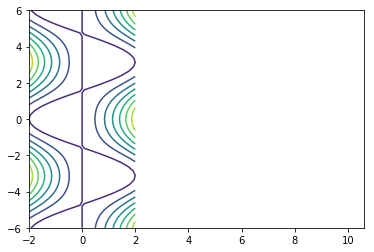

In [110]:
xg, yg = np.linspace(-2, 2, 51), np.linspace(-6, 6, 51)
def mat_fun(x_g, x_):
    Z = np.zeros((xg.size, yg.size))

    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[j, i] = test_fun(np.array([xg[i], yg[j]]))
    return Z
X, Y = np.meshgrid(xg,yg)
plt.contour(X, Y, mat_fun(xg, yg))
plt.plot(iterates[0,:],iterates[1,:])

In [91]:
iterates

[matrix([[nan],
         [nan]])]

In [71]:
x[:]

matrix([[10.],
        [ 1.]])

In [11]:
np.dot(S[:,1],np.array([1,2,3])) 

28

In [48]:
for i in range(2,0,-1): print(i)

2
1


In [68]:
S[-1,:]

array([0., 0.])